In [1]:
import bokeh.plotting as bpl
import cv2
import glob
import logging
import matplotlib.pyplot as plt
import numpy as np
import os

try:
    cv2.setNumThreads(0)
except():
    pass

try:
    if __IPYTHON__:
        # this is used for debugging purposes only. allows to reload classes
        # when changed
        get_ipython().magic('load_ext autoreload')
        get_ipython().magic('autoreload 2')
except NameError:
    pass

import caiman as cm
from caiman.motion_correction import MotionCorrect
from caiman.source_extraction.cnmf import cnmf as cnmf
from caiman.source_extraction.cnmf import params as params
from caiman.utils.utils import download_demo
from caiman.utils.visualization import plot_contours, nb_view_patches, nb_plot_contour
bpl.output_notebook()


/home/julianarhee/anaconda2/envs/caiman/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.incremental_pca module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/julianarhee/anaconda2/envs/caiman/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/julianarhee/anaconda2/envs/caiman/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy,

Loading BokehJS ...

In [15]:
import json
import re
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split('(\d+)', text) ]


In [3]:
logging.basicConfig(format=
                          "%(relativeCreated)12d [%(filename)s:%(funcName)20s():%(lineno)s] [%(process)d] %(message)s",
                    filename="/tmp/caiman.log",
                    level=logging.WARNING)

In [4]:

def get_file_paths(results_dir, mm_prefix='Yr'):
    try:
        mparams_fpath = os.path.join(results_dir, '%s_memmap-params.json' % mm_prefix)
        print("Loading memmap params...")
        print(mparams_fpath)
        with open(mparams_fpath, 'r') as f:
            mparams = json.load(f)
        fnames = mparams['fnames']
    except Exception as e:
        print(e)
        print("Unable to load memmap params, trying alt.")
        try:
            fnames = []
            if 'downsample' in mm_prefix:
                print("checking scratch")
                fovdir = results_dir.split('/caiman_results/')[0]
                fov = os.path.split(fovdir)[-1]
                sessiondir = os.path.split(fovdir)[0]
                session = os.path.split(sessiondir)[-1]
                animalid = os.path.split(os.path.split(sessiondir)[0])[-1]
                print("Animal: %s, Fov: %s, Session: %s" % (animalid, fov, session))
                fnames = sorted(glob.glob(os.path.join('/n/scratchlfs/cox_lab/julianarhee/downsampled/*%s*/*.tif' % mm_prefix)), key=natural_keys)
                print(fnames[0:5]) 
            if len(fnames)==0 and 'downsample' not in mm_prefix: 
                dpath = glob.glob(os.path.join(results_dir, 'memmap', '*%s*.npz' % mm_prefix))[0]#) [0]) 
                minfo = np.load(dpath)
                fnames = sorted(list(minfo['mmap_fnames']))
        except Exception as e:
            print("unable to load file names.")
            return None
    
    return fnames #fnames = mparams['fnames']

def get_full_memmap_path(results_dir, framestr='order_C_frames', prefix='Yr'):
    print("Getting full mmap path for prefix: %s" % prefix)
    print("-- dir: %s" % results_dir)
    print(glob.glob(os.path.join(results_dir, 'memmap', '*%s*.mmap' % prefix))) 
    try:
        fname_new = glob.glob(os.path.join(results_dir, 'memmap', '*%s*_d*%s*_.mmap' % (prefix, framestr)))
        if len(fname_new) > 1:
            nframes = max([int(i.split('_')[-2]) for i in fname_new])
            framestr = '_frames_%i_' % nframes
            fname_new = glob.glob(os.path.join(results_dir, 'memmap', '*%s*_d*%s*_.mmap' % (prefix, framestr)))[0]
        else:
            assert len(fname_new)==1, "Unique fname_new not found: %s" % str(fname_new)
            fname_new = fname_new[0] 
        mm_prefix = os.path.splitext(os.path.split(fname_new)[-1])[0].split('_d1_')[0]
        print("CORRECTED PREFIX: %s" % mm_prefix)
    except Exception as e:
        print(e)
        return None
    return fname_new, mm_prefix


In [5]:
rootdir = '/n/coxfs01/2p-data'
animalid = 'JC084'
session = '20190522'
fov = 'FOV1_zoom2p0x'
experiment = 'gratings'

results_dir = os.path.join(rootdir, animalid, session, fov, 'caiman_results', experiment)

mm_prefix = 'JC084-20190522-FOV1_zoom2p0x-gratings-Yr'

fnames = get_file_paths(results_dir, mm_prefix=mm_prefix)


Loading memmap params...
/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/caiman_results/gratings/JC084-20190522-FOV1_zoom2p0x-gratings-Yr_memmap-params.json


In [6]:
fnames

['/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/gratings_run1/raw_d0390b/fov1_gratings_00001.tif',
 '/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/gratings_run1/raw_d0390b/fov1_gratings_00002.tif',
 '/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/gratings_run1/raw_d0390b/fov1_gratings_00003.tif',
 '/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/gratings_run1/raw_d0390b/fov1_gratings_00004.tif',
 '/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/gratings_run1/raw_d0390b/fov1_gratings_00005.tif',
 '/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/gratings_run1/raw_d0390b/fov1_gratings_00006.tif',
 '/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/gratings_run1/raw_d0390b/fov1_gratings_00007.tif',
 '/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/gratings_run1/raw_d0390b/fov1_gratings_00008.tif',
 '/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/gratings_run2/raw_a8b68a/fov1_gratings_00001.tif',
 '/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/gratings_run2/raw_a8b68a/fov1_gratings_00

In [7]:
# dataset dependent parameters
fr = 44.65                             # imaging rate in frames per second
decay_time = 0.4                    # length of a typical transient in seconds

# motion correction parameters
#strides = (48, 48)          # start a new patch for pw-rigid motion correction every x pixels
#overlaps = (24, 24)         # overlap between pathes (size of patch strides+overlaps)
#max_shifts = (6,6)          # maximum allowed rigid shifts (in pixels)
#max_deviation_rigid = 3     # maximum shifts deviation allowed for patch with respect to rigid shifts
#pw_rigid = False             # flag for performing non-rigid motion correction

# parameters for source extraction and deconvolution
p = 1                       # order of the autoregressive system
gnb = 2                     # number of global background components
merge_thr = 0.85            # merging threshold, max correlation allowed
rf = 25                     # half-size of the patches in pixels. e.g., if rf=25, patches are 50x50
stride_cnmf = 12             # amount of overlap between the patches in pixels
K = 8                       # number of components per patch
gSig = [2, 2]               # expected half size of neurons in pixels
method_init = 'greedy_roi'  # initialization method (if analyzing dendritic data using 'sparse_nmf')
ssub = 1                    # spatial subsampling during initialization
tsub = 1                    # temporal subsampling during intialization

# parameters for component evaluation
min_SNR = 2.0               # signal to noise ratio for accepting a component
rval_thr = 0.85              # space correlation threshold for accepting a component
cnn_thr = 0.99              # threshold for CNN based classifier
cnn_lowest = 0.1 # neurons with cnn probability lower than this value are rejected


In [8]:
opts_dict = {'fnames': fnames,
            'fr': fr,
            'decay_time': decay_time,
            #'strides': strides,
            #'overlaps': overlaps,
            #'max_shifts': max_shifts,
            #'max_deviation_rigid': max_deviation_rigid,
            #'pw_rigid': pw_rigid,
            'p': p,
            'nb': gnb,
            'rf': rf,
            'K': K, 
            'stride': stride_cnmf,
            'method_init': method_init,
            'rolling_sum': True,
            'only_init': True,
            'ssub': ssub,
            'tsub': tsub,
            'merge_thr': merge_thr, 
            'min_SNR': min_SNR,
            'rval_thr': rval_thr,
            'use_cnn': True,
            'min_cnn_thr': cnn_thr,
            'cnn_lowest': cnn_lowest}

opts = params.CNMFParams(params_dict=opts_dict)

In [9]:
#%% start a cluster for parallel processing (if a cluster already exists it will be closed and a new session will be opened)
if 'dview' in locals():
    cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=1, single_thread=True)
dview=None

In [10]:
fname_new

NameError: name 'fname_new' is not defined

In [11]:

#%% MEMORY MAPPING
# memory map the file in order 'C'
fname_new, _ = get_full_memmap_path(results_dir, framestr='_frames_142910', prefix=mm_prefix)
print("Extracting CNMF from: %s" % fname_new)
    
# now load the file
Yr, dims, T = cm.load_memmap(fname_new)
images = np.reshape(Yr.T, [T] + list(dims), order='F') 
    #load frames in python format (T x X x Y)
    

Getting full mmap path for prefix: JC084-20190522-FOV1_zoom2p0x-gratings-Yr
-- dir: /n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/caiman_results/gratings
['/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/caiman_results/gratings/memmap/JC084-20190522-FOV1_zoom2p0x-gratings-Yr_d1_512_d2_512_d3_1_order_C_frames_142910_.mmap']
CORRECTED PREFIX: JC084-20190522-FOV1_zoom2p0x-gratings-Yr
Extracting CNMF from: /n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/caiman_results/gratings/memmap/JC084-20190522-FOV1_zoom2p0x-gratings-Yr_d1_512_d2_512_d3_1_order_C_frames_142910_.mmap


In [12]:
print("images:", images.max(), images.min())

images: 0.0 0.0


In [16]:
rig_mfiles = sorted(glob.glob(os.path.join(rootdir, animalid, session, fov, '%s*' % experiment, 'raw_*', '*_rig_*.mmap')), key=natural_keys)

In [70]:
rig_mfiles[0]

'/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/gratings_run1/raw_d0390b/fov1_gratings_00001_rig__d1_512_d2_512_d3_1_order_F_frames_4610_.mmap'

In [71]:
# now load the file
Yr, dims, T = cm.load_memmap(rig_mfiles[-1])
print(dims)
print(T)
images = np.reshape(Yr.T, [T] + list(dims), order='F') 


(512, 512)
4610


In [72]:
print("images:", images.max(), images.min())

images: 26354.438 -933.7417


In [73]:
img0 = images.sum(axis=0)


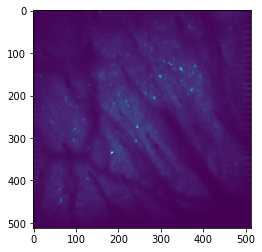

In [74]:
pl.figure()
pl.imshow(img0)



In [75]:
if np.isfortran(Yr):
    raise Exception('The file should be in C order (see save_memmap function)')


Exception: The file should be in C order (see save_memmap function)

In [78]:
print(base_name)
print(dview)
n_chunks = 100
print(n_chunks)


/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/caiman_results/gratings/memmap/JC084-20190522-FOV1_zoom2p0x-gratings-Yr
None
100


In [96]:
base_name

'/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/caiman_results/gratings/memmap/JC084-20190522-FOV1_zoom2p0x-gratings-Yr'

In [ ]:
start_t = time.time() 

fname_new = cm.save_memmap_join(rig_mfiles, base_name=base_name, dview=dview, n_chunks=n_chunks)

end_t = time.time() - start_t


In [ ]:
print("DONE JOINING MMAP FILES!")
print("Elapsed: {0:.2f}sec".format(end_t))  

In [87]:
Yr, dims, T = cm.load_memmap(fname_new)
print(dims, T)
images = np.reshape(Yr.T, [T] + list(dims), order='F') 
print(images.shape)
img = images.sum(axis=0)


(512, 512) 18440
(18440, 512, 512)


25660.0 -1836.0


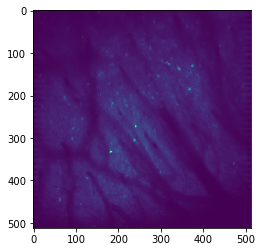

In [88]:
pl.figure()
pl.imshow(img)
print(images.max(), images.min())

In [55]:
f1 = '/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/caiman_results/gratings/memmap/file00001_fov1_gratings_00001_rig__d1_512_d2_512_d3_1_order_C_frames_4610_.mmap'
f2 = '/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/caiman_results/gratings/memmap/gratings-downsample-1-mcorrected0006_d1_512_d2_512_d3_1_order_F_frames_4610_.mmap'


In [59]:
Yr, dims, T = cm.load_memmap(f1)
print(dims, T)
images = np.reshape(Yr.T, [T] + list(dims), order='F') 
print(images.shape)
img = images.sum(axis=0)


(512, 512) 4610
(4610, 512, 512)


In [68]:
Yr, dims, T = cm.load_memmap(f2)
print(dims, T)
images = np.reshape(Yr.T, list(dims) + [T], order='C') 
print(images.shape)
img2 = images.sum(axis=-1)


(512, 512) 4610
(512, 512, 4610)


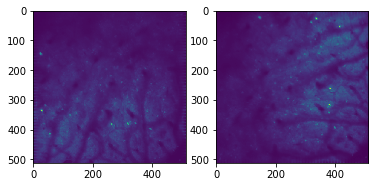

In [69]:
pl.figure()
pl.subplot(1,2,1)
pl.imshow(img)
pl.subplot(1,2,2)
pl.imshow(img2)



In [39]:

def load_mc_results(results_dir, mc, prefix='Yr'):
    try:
        res = np.load(os.path.join(results_dir, '%s_mc-rigid.npz' % prefix), allow_pickle=True)
        #mc = mc_results[mc] 
        print(list(res.keys()))
        mc.fname = res['fname']
        mc.max_shifts = res['max_shifts']
        mc.min_mov = res['min_mov']
        mc.border_nan = res['border_nan']
        mc.fname_tot_rig = list(res['fname_tot_rig'])
        mc.total_template_rig = res['total_template_rig']
        mc.templates_rig = res['templates_rig']
        mc.shifts_rig = res['shifts_rig']
        mc.mmap_file = res['mmap_file']
        mc.border_to_0 = res['border_to_0']
        mc.gSig_filt = res['gSig_filt']

    except Exception as e:
        print(e)
        print("Error loading MC")
        return None

    return mc 

In [40]:
print("... Checking for existing .mmap files")
mc = MotionCorrect(fnames, **opts.get_group('motion'))
mc = load_mc_results(results_dir, mc, prefix=mm_prefix)
assert mc is not None, "---> No completed MC found. Running now..."
assert len(mc.mmap_file)==len(fnames), "--> Incorrect .mmap files found (%i - should be %i)" % (len(mc.mmap_file), len(fnames))

... Checking for existing .mmap files
['fname', 'max_shifts', 'min_mov', 'border_nan', 'fname_tot_rig', 'total_template_rig', 'templates_rig', 'shifts_rig', 'mmap_file', 'border_to_0', 'gSig_filt']


In [28]:
nframes_total = sum([int(mf.split('_')[-2]) for mf in mc.mmap_file])
d1, d2 = mc.total_template_rig.shape
dimstr = 'd1_%i_d2_%i' % (d1, d2)
framestr = 'order_C_frames_%i' % nframes_total
print('... checking for existing mmap total: %s, %s' % (dimstr, framestr))
bord_px = np.ceil(np.max(np.abs(mc.shifts_rig))).astype(np.int)
print(bord_px)

... checking for existing mmap total: d1_512_d2_512, order_C_frames_142910
7


In [95]:
list(mc.mmap_file) == rig_mfiles

True

In [33]:
import pylab as pl
import time

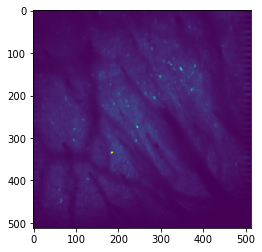

In [52]:
pl.figure()
pl.imshow(mc.total_template_rig)

In [42]:
start_t = time.time() 
base_name = '%s/memmap/%s' % (results_dir, mm_prefix)
print("... saving total result to: %s" % base_name)


... saving total result to: /n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/caiman_results/gratings/memmap/JC084-20190522-FOV1_zoom2p0x-gratings-Yr


In [50]:
mc.min_mov

array(-372., dtype=float32)

In [43]:
fname_new = cm.save_memmap(mc.fname_tot_rig, base_name=base_name, border_to_0=bord_px, order='C', dview=dview)     
end_t = time.time() - start_t

KeyboardInterrupt: 

In [47]:
order='C'
for file__ in mc.fname_tot_rig:
    print(file__)
    if ('order_' + order not in file__) or ('.mmap' not in file__):
        print('no order')

/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/gratings_run1/raw_d0390b/fov1_gratings_00001_rig__d1_512_d2_512_d3_1_order_F_frames_4610_.mmap
no order
/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/gratings_run1/raw_d0390b/fov1_gratings_00002_rig__d1_512_d2_512_d3_1_order_F_frames_4610_.mmap
no order
/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/gratings_run1/raw_d0390b/fov1_gratings_00003_rig__d1_512_d2_512_d3_1_order_F_frames_4610_.mmap
no order
/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/gratings_run1/raw_d0390b/fov1_gratings_00004_rig__d1_512_d2_512_d3_1_order_F_frames_4610_.mmap
no order
/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/gratings_run1/raw_d0390b/fov1_gratings_00005_rig__d1_512_d2_512_d3_1_order_F_frames_4610_.mmap
no order
/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/gratings_run1/raw_d0390b/fov1_gratings_00006_rig__d1_512_d2_512_d3_1_order_F_frames_4610_.mmap
no order
/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/gratings_run1/raw_d0390b/fov1_gratings_0

In [90]:
images.shape

(18440, 512, 512)

# Run CNMF on patches

In [91]:
%%capture
#%% RUN CNMF ON PATCHES
# First extract spatial and temporal components on patches and combine them
# for this step deconvolution is turned off (p=0). If you want to have
# deconvolution within each patch change params.patch['p_patch'] to a
# nonzero value
cnm = cnmf.CNMF(n_processes, params=opts, dview=dview)
cnm = cnm.fit(images)

In [93]:
print("C:", cnm.estimates.C.shape)
print("A:", cnm.estimates.A.shape)

C: (1179, 18440)
A: (262144, 1179)


In [29]:
indices=(slice(None), slice(None))
indices

(slice(None, None, None), slice(None, None, None))

In [32]:
if isinstance(indices, slice):
    indices = [indices]
if isinstance(indices, tuple):
    indices = list(indices)
indices = [slice(None)] + indices


In [34]:
if len(indices) < len(images.shape):
    print(len(indices))
    indices = indices + [slice(None)]*(len(images.shape) - len(indices))

In [35]:
dims_orig = images.shape[1:]
dims_sliced = images[tuple(indices)].shape[1:]
is_sliced = (dims_orig != dims_sliced)
print(is_sliced)
print(cnm.params.get('patch', 'rf'))
print(cnm.dview)
if cnm.params.get('patch', 'rf') is None and (is_sliced or 'ndarray' in str(type(images))):
    images = images[tuple(indices)]
    cnm.dview = None
    logging.info("Parallel processing in a single patch "
                    "is not available for loaded in memory or sliced" +
                    " data.")

False
25
None


In [37]:
images.shape

(142910, 512, 512)

In [39]:

T = images.shape[0]
cnm.params.set('online', {'init_batch': T})
cnm.dims = images.shape[1:]
#self.params.data['dims'] = images.shape[1:]
Y = np.transpose(images, list(range(1, len(cnm.dims) + 1)) + [0])
print("Y:", Y.shape)
Yr = np.transpose(np.reshape(images, (T, -1), order='F'))
if np.isfortran(Yr):
    raise Exception('The file is in F order, it should be in C order (see save_memmap function)')
print("Yr:", Yr.shape)

logging.info((T,) + cnm.dims)

Y: (512, 512, 142910)
Yr: (262144, 142910)


In [40]:
 list(range(1, len(cnm.dims) + 1)) + [0]

[1, 2, 0]

In [42]:
# Make sure filename is pointed correctly (numpy sets it to None sometimes)
try:
    Y.filename = images.filename
    Yr.filename = images.filename
    cnm.mmap_file = images.filename
except AttributeError:  # if no memmapping cause working with small data
    print("NO MEMMAP")
    pass


In [43]:
images.filename

'/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/caiman_results/gratings/memmap/JC084-20190522-FOV1_zoom2p0x-gratings-Yr_d1_512_d2_512_d3_1_order_C_frames_142910_.mmap'

In [45]:

# update/set all options that depend on data dimensions
# number of rows, columns [and depths]
cnm.params.set('spatial', {'medw': (3,) * len(cnm.dims),
                            'se': np.ones((3,) * len(cnm.dims), dtype=np.uint8),
                            'ss': np.ones((3,) * len(cnm.dims), dtype=np.uint8)
                            })

print(('Using ' + str(cnm.params.get('patch', 'n_processes')) + ' processes'))
if cnm.params.get('preprocess', 'n_pixels_per_process') is None:
    avail_memory_per_process = psutil.virtual_memory()[
        1] / 2.**30 / cnm.params.get('patch', 'n_processes')
    mem_per_pix = 3.6977678498329843e-09
    npx_per_proc = np.int(avail_memory_per_process / 8. / mem_per_pix / T)
    npx_per_proc = np.int(np.minimum(npx_per_proc, np.prod(self.dims) // self.params.get('patch', 'n_processes')))
    cnm.params.set('preprocess', {'n_pixels_per_process': npx_per_proc})

print( cnm.params.get('preprocess', 'n_pixels_per_process') )
cnm.params.set('spatial', {'n_pixels_per_process': cnm.params.get('preprocess', 'n_pixels_per_process')})

print('using ' + str(cnm.params.get('preprocess', 'n_pixels_per_process')) + ' pixels per process')
print('using ' + str(cnm.params.get('spatial', 'block_size_spat')) + ' block_size_spat')
print('using ' + str(cnm.params.get('temporal', 'block_size_temp')) + ' block_size_temp')


Using 1 processes
3818
using 3818 pixels per process
using 5000 block_size_spat
using 5000 block_size_temp


In [46]:
cnm.params.get('patch', 'rf') is None

False

In [47]:
if cnm.params.get('patch', 'stride') is None:
    cnm.params.set('patch', {'stride': np.int(cnm.params.get('patch', 'rf') * 2 * .1)})
    print(
        ('Setting the stride to 10% of 2*rf automatically:' + str(cnm.params.get('patch', 'stride'))))


In [48]:
if type(images) is np.ndarray:
    raise Exception(
        'You need to provide a memory mapped file as input if you use patches!!')


In [49]:
print("init, nb:", cnm.params.get('init', 'nb'))
print("patch, memory_fact:", cnm.params.get('patch', 'memory_fact'))
print("patch, border_pix:", cnm.params.get('patch', 'border_pix'))

print(cnm.params.get('patch', 'low_rank_background'))
print(cnm.params.get('patch', 'del_duplicates'))

border_pix = cnm.params.get('patch', 'border_pix')

init, nb: 2
patch, memory_fact: 1
patch, border_pix: 0
True
False


In [93]:
import caiman as cm
from caiman.source_extraction.cnmf.map_reduce import run_CNMF_patches, cnmf_patches
from caiman.mmapping import load_memmap


In [57]:

cnm.estimates.A, cnm.estimates.C, cnm.estimates.YrA, cnm.estimates.b, cnm.estimates.f, \
    cnm.estimates.sn, cnm.estimates.optional_outputs = run_CNMF_patches(
        images.filename, cnm.dims + (T,), cnm.params,
        dview=cnm.dview, memory_fact=cnm.params.get('patch', 'memory_fact'),
        gnb=cnm.params.get('init', 'nb'), border_pix=cnm.params.get('patch', 'border_pix'),
        low_rank_background=cnm.params.get('patch', 'low_rank_background'),
        del_duplicates=cnm.params.get('patch', 'del_duplicates'),
        indices=indices)


In [58]:
print("A:", cnm.estimates.A)
print("C:", cnm.estimates.C)

A: 
C: []


#### run_CNMF_patches

In [61]:
file_name = images.filename
print(file_name)
shape = cnm.dims + (T,)
print(shape)
params = cnm.params

dview=cnm.dview
memory_fact=1
gnb=cnm.params.get('init', 'nb')
print(gnb)
border_pix = cnm.params.get('patch', 'border_pix')
low_rank_background =cnm.params.get('patch', 'low_rank_background')
del_duplicates=cnm.params.get('patch', 'del_duplicates')

/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/caiman_results/gratings/memmap/JC084-20190522-FOV1_zoom2p0x-gratings-Yr_d1_512_d2_512_d3_1_order_C_frames_142910_.mmap
(512, 512, 142910)
2


In [62]:

dims = shape[:-1]
d = np.prod(dims)
T = shape[-1]

rf = params.get('patch', 'rf')
if rf is None:
    rf = 16
if np.isscalar(rf):
    rfs = [rf] * len(dims)
else:
    rfs = rf

stride = params.get('patch', 'stride')
if stride is None:
    stride = 4
if np.isscalar(stride):
    strides = [stride] * len(dims)
else:
    strides = stride

In [63]:
strides

[12, 12]

In [69]:
from copy import deepcopy

In [70]:

params_copy = deepcopy(params)
npx_per_proc = np.prod(rfs) // memory_fact
params_copy.set('preprocess', {'n_pixels_per_process': npx_per_proc})
params_copy.set('spatial', {'n_pixels_per_process': npx_per_proc})
params_copy.set('temporal', {'n_pixels_per_process': npx_per_proc})


In [76]:
from caiman.cluster import extract_patch_coordinates
import time

In [73]:

idx_flat, idx_2d = extract_patch_coordinates(
    dims, rfs, strides, border_pix=border_pix, indices=indices[1:])
args_in = []
patch_centers = []
for id_f, id_2d in zip(idx_flat, idx_2d):
    #        print(id_2d)
    args_in.append((file_name, id_f, id_2d, params_copy))
    if del_duplicates:
        foo = np.zeros(d, dtype=bool)
        foo[id_f] = 1
        patch_centers.append(scipy.ndimage.center_of_mass(
            foo.reshape(dims, order='F')))
print('Patch size: {0}'.format(id_2d))

Patch size: (50, 50)


In [77]:
st = time.time()
if dview is not None:
    if 'multiprocessing' in str(type(dview)):
        file_res = dview.map_async(cnmf_patches, args_in).get(4294967)
    else:
        try:
            file_res = dview.map_sync(cnmf_patches, args_in)
            dview.results.clear()
        except:
            print('Something went wrong')
            raise
        finally:
            print('Patch processing complete')

else:
    file_res = list(map(cnmf_patches, args_in))

print('Elapsed time for processing patches: \
             {0}s'.format(str(time.time() - st).split('.')[0]))

Elapsed time for processing patches:              3293s


In [89]:
R = cnmf_patches(args_in[0])

#### cnmf_patches()

In [91]:
file_name, idx_, shapes, params = args_in[0]
print(file_name)
print(idx_)
print(shapes)


/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/caiman_results/gratings/memmap/JC084-20190522-FOV1_zoom2p0x-gratings-Yr_d1_512_d2_512_d3_1_order_C_frames_142910_.mmap
[    0     1     2 ... 25648 25649 25650]
(51, 51)


In [110]:
Yr, dims, timesteps = load_memmap(file_name)
print(Yr.shape)

(262144, 142910)


In [97]:
timesteps

142910

In [98]:

# slicing array (takes the min and max index in n-dimensional space and
# cuts the box they define)
# for 2d a rectangle/square, for 3d a rectangular cuboid/cube, etc.
upper_left_corner = min(idx_)
lower_right_corner = max(idx_)
print(upper_left_corner, lower_right_corner)

indices = np.unravel_index([upper_left_corner, lower_right_corner],
                           dims, order='F')  # indices as tuples
slices = [slice(min_dim, max_dim + 1) for min_dim, max_dim in indices]
# insert slice for timesteps, equivalent to :
slices.insert(0, slice(timesteps))

0 25650


In [99]:
slices

[slice(None, 142910, None), slice(0, 51, None), slice(0, 51, None)]

In [111]:

images = np.reshape(Yr.T, [timesteps] + list(dims), order='F')
images.shape

#images = np.reshape(Yr.T, [T] + list(dims), order='F') #np.reshape(Yr, dims + (T,), order='F')


(142910, 512, 512)

In [113]:
Yr.max()

0.0

In [101]:
if params.get('patch', 'in_memory'):
    print('in_memory')
    images = np.array(images[slices], dtype=np.float32)
else:
    images = images[slices]


in_memory


In [104]:
import pylab as pl

In [ ]:
# count components
count = 0
count_bgr = 0
patch_id = 0
num_patches = len(file_res)
for jj, fff in enumerate(file_res):
    if fff is not None:
        idx_, shapes, A, b, C, f, S, bl, c1, neurons_sn, g, sn, _, YrA = fff
        print(C.shape)
        for _ in range(np.shape(b)[-1]):
            count_bgr += 1

        A = A.tocsc()
        if del_duplicates:
            keep = []
            for ii in range(np.shape(A)[-1]):
                neuron_center = (np.array(scipy.ndimage.center_of_mass(
                    A[:, ii].toarray().reshape(shapes, order='F'))) -
                    np.array(shapes) / 2. + np.array(patch_centers[jj]))
                if np.argmin([np.linalg.norm(neuron_center - p) for p in
                              np.array(patch_centers)]) == jj:
                    keep.append(ii)
            A = A[:, keep]
            file_res[jj][2] = A
            file_res[jj][4] = C[keep]
            if S is not None:
                file_res[jj][6] = S[keep]
                file_res[jj][7] = bl[keep]
                file_res[jj][8] = c1[keep]
                file_res[jj][9] = neurons_sn[keep]
                file_res[jj][10] = g[keep]
            file_res[jj][-1] = YrA[keep]

        # for ii in range(np.shape(A)[-1]):
        #     new_comp = A[:, ii] / np.sqrt(A[:, ii].power(2).sum())
        #     if new_comp.sum() > 0:
        #         count += 1
        count += np.sum(A.sum(0) > 0)

        patch_id += 1

In [ ]:

# INITIALIZING
nb_patch = params.get('patch', 'nb_patch')
C_tot = np.zeros((count, T), dtype=np.float32)
if params.get('init', 'center_psf'):
    S_tot = np.zeros((count, T), dtype=np.float32)
else:
    S_tot = None
YrA_tot = np.zeros((count, T), dtype=np.float32)
F_tot = np.zeros((max(0, num_patches * nb_patch), T), dtype=np.float32)
mask = np.zeros(d, dtype=np.uint8)
sn_tot = np.zeros((d))
